# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [1]:
import os

from sklearn.linear_model import LogisticRegression

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [2]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [3]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [4]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [5]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [6]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [7]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [8]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

# AIMLAC Coursework

# Task 1

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.svm import SVC
from sklearn.datasets import make_moons

import h5py
import imageio
from PIL import Image 
from utils import * # image processing functions from utils.py

In [10]:
print (f'a) number of training examples: {X_tr.shape[0]}')
print (f'a2) shape of training examples: {X_tr.shape}')
print (f'b) number of testing examples: {X_test.shape[0]}')
print (f'b2) shape of testing examples: {X_test.shape}')

print (f'c) number of training examples: {y_tr.shape[0]}')
print (f'c2) shape of training examples: {y_tr.shape}')
print (f'd) number of testing examples: {y_test.shape[0]}')
print (f'd2) shape of testing examples: {y_test.shape}')

a) number of training examples: 46509
a2) shape of training examples: (46509, 6)
b) number of testing examples: 5973
b2) shape of testing examples: (5973, 6)
c) number of training examples: 46509
c2) shape of training examples: (46509,)
d) number of testing examples: 5973
d2) shape of testing examples: (5973,)


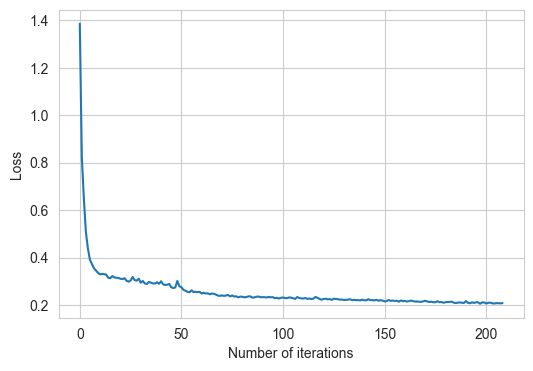

In [12]:
nn_clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    activation='relu',
                    solver='adam',
                    alpha=0,
                    learning_rate_init=1e-3,
                    max_iter=1000,
                    random_state=1
                    )
nn_clf.fit(X_tr, y_tr.flatten())

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nn_clf.loss_curve_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')
plt.savefig('./figures/01-loss_iter.png')

Training accuracy:  0.92
Training accuracy:  0.88


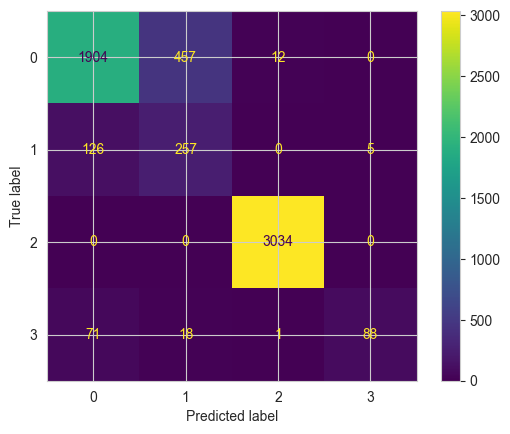

In [14]:
print('Training accuracy: ', round(nn_clf.score(X_tr, y_tr),2))
print('Training accuracy: ', round(nn_clf.score(X_test, y_test),2))

ConfusionMatrixDisplay.from_estimator(nn_clf, X_test, y_test)

In [15]:
# Evaluate and Tune Hyperparameters

alphas = np.logspace(-3, -0, 100)
learning_rates = np.logspace(-4, -2, 100)
parameters = {'learning_rate_init':learning_rates, 'alpha':alphas}

nn = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    activation='relu',
                    solver='adam',
                    alpha=0,
                    learning_rate_init=1e-3,
                    max_iter=1000,
                    # n_iter_no_change=25,
                    random_state=1
                    )

clf = RandomizedSearchCV(nn, parameters, scoring='accuracy', n_iter=10, cv=3, verbose=2)

clf.fit(X_tr, y_tr.flatten())
clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END alpha=0.024770763559917114, learning_rate_init=0.00020092330025650479; total time=  15.5s
[CV] END alpha=0.024770763559917114, learning_rate_init=0.00020092330025650479; total time=  12.9s
[CV] END alpha=0.024770763559917114, learning_rate_init=0.00020092330025650479; total time=  12.1s
[CV] END alpha=0.023101297000831605, learning_rate_init=0.004977023564332114; total time=   4.6s
[CV] END alpha=0.023101297000831605, learning_rate_init=0.004977023564332114; total time=   7.2s
[CV] END alpha=0.023101297000831605, learning_rate_init=0.004977023564332114; total time=   5.1s
[CV] END alpha=0.046415888336127795, learning_rate_init=0.0019630406500402726; total time=   5.4s
[CV] END alpha=0.046415888336127795, learning_rate_init=0.0019630406500402726; total time=   5.1s
[CV] END alpha=0.046415888336127795, learning_rate_init=0.0019630406500402726; total time=   5.6s
[CV] END alpha=0.07054802310718646, learning_rate_init=0.

{'learning_rate_init': 0.0004641588833612782, 'alpha': 0.01873817422860384}

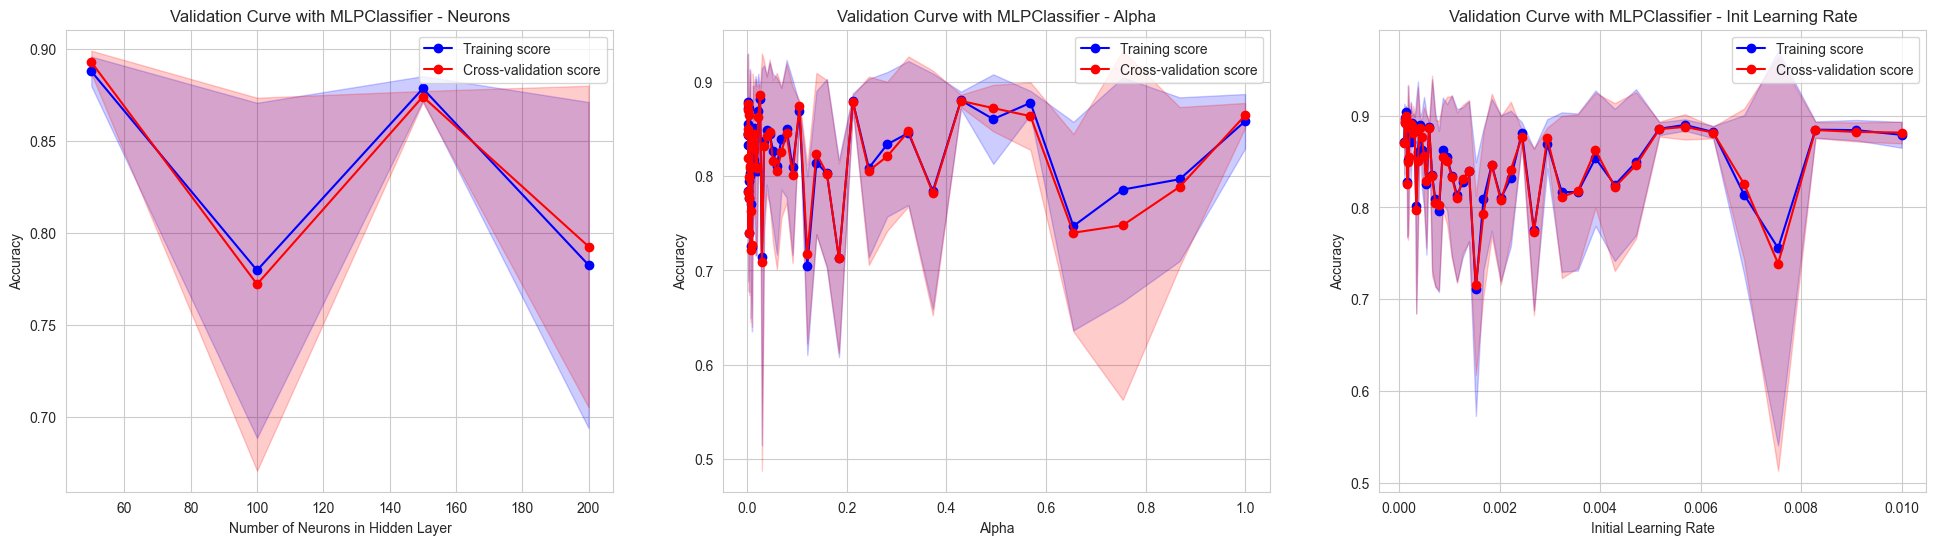

In [17]:
# Define the range of values for the hyperparameter (e.g., number of neurons in hidden layer)
hidden_layer_sizes_range = [50, 100, 150, 200]
alphas = np.logspace(-3, -0, 50)
learning_rates = np.logspace(-4, -2, 50)

# Create the MLPClassifier
clf = MLPClassifier(activation='relu', solver='adam', max_iter=500)

# Plot validation curve for the number of neurons in hidden layer
hls_train_scores, hls_test_scores = validation_curve(
    clf, X_tr, y_tr.flatten(), param_name="hidden_layer_sizes", param_range=hidden_layer_sizes_range,
    cv=5, scoring="accuracy", n_jobs=-1)

alp_train_scores, alp_test_scores = validation_curve(
    clf, X_tr, y_tr.flatten(), param_name="alpha", param_range=alphas,
    cv=5, scoring="accuracy", n_jobs=-1)

lrt_train_scores, lrt_test_scores = validation_curve(
    clf, X_tr, y_tr.flatten(), param_name="learning_rate_init", param_range=learning_rates,
    cv=5, scoring="accuracy", n_jobs=-1)

hls_train_mean = np.mean(hls_train_scores, axis=1)
hls_train_std = np.std(hls_train_scores, axis=1)
hls_test_mean = np.mean(hls_test_scores, axis=1)
hls_test_std = np.std(hls_test_scores, axis=1)

alp_train_mean = np.mean(alp_train_scores, axis=1)
alp_train_std = np.std(alp_train_scores, axis=1)
alp_test_mean = np.mean(alp_test_scores, axis=1)
alp_test_std = np.std(alp_test_scores, axis=1)

lrt_train_mean = np.mean(lrt_train_scores, axis=1)
lrt_train_std = np.std(lrt_train_scores, axis=1)
lrt_test_mean = np.mean(lrt_test_scores, axis=1)
lrt_test_std = np.std(lrt_test_scores, axis=1)

# Plot validation curve
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
axes[0].plot(hidden_layer_sizes_range, hls_train_mean, label="Training score", color="blue", marker='o')
axes[0].plot(hidden_layer_sizes_range, hls_test_mean, label="Cross-validation score", color="red", marker='o')

axes[1].plot(alphas, alp_train_mean, label="Training score", color="blue", marker='o')
axes[1].plot(alphas, alp_test_mean, label="Cross-validation score", color="red", marker='o')

axes[2].plot(learning_rates, lrt_train_mean, label="Training score", color="blue", marker='o')
axes[2].plot(learning_rates, lrt_test_mean, label="Cross-validation score", color="red", marker='o')

# Plot the standard deviations
axes[0].fill_between(hidden_layer_sizes_range, hls_train_mean - hls_train_std, hls_train_mean + hls_train_std, color="blue", alpha=0.2)
axes[0].fill_between(hidden_layer_sizes_range, hls_test_mean - hls_test_std, hls_test_mean + hls_test_std, color="red", alpha=0.2)

axes[1].fill_between(alphas, alp_train_mean - alp_train_std, alp_train_mean + alp_train_std, color="blue", alpha=0.2)
axes[1].fill_between(alphas, alp_test_mean - alp_test_std, alp_test_mean + alp_test_std, color="red", alpha=0.2)

axes[2].fill_between(learning_rates, lrt_train_mean - lrt_train_std, lrt_train_mean + lrt_train_std, color="blue", alpha=0.2)
axes[2].fill_between(learning_rates, lrt_test_mean - lrt_test_std, lrt_test_mean + lrt_test_std, color="red", alpha=0.2)

# Add labels, title, and legend
axes[0].set_title("Validation Curve with MLPClassifier - Neurons")
axes[0].set_xlabel("Number of Neurons in Hidden Layer")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="best")

axes[1].set_title("Validation Curve with MLPClassifier - Alpha")
axes[1].set_xlabel("Alpha")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="best")

axes[2].set_title("Validation Curve with MLPClassifier - Init Learning Rate")
axes[2].set_xlabel("Initial Learning Rate")
axes[2].set_ylabel("Accuracy")
axes[2].legend(loc="best")

plt.savefig('./figures/03-val_curves.png')
plt.show()

# Task 2

In [ ]:
# Decision Tree Ensemble

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import graphviz

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_tr, y_tr.flatten())

print("Training set accuracy: {}".format(tree_model.score(X_tr, y_tr)))
print("Test set accuracy: {}".format(tree_model.score(X_test, y_test)))

In [ ]:
num_models = 50
sample_size = 5000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # TODO
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # TODO
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

In [ ]:
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(np.int64(votes[test_point])).argmax()
    
    return combined_predictions

In [ ]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Explore accuracy change with number of models

In [ ]:
def bagging_by_nmodels(num_models):
    sample_size = 2000  # training set size.
    np.random.seed(0)
    
    all_models = []
    for m in range(num_models):
        # TODO
        # Sample with replacement from the training set. 
        # Each sample should contain sample_size data points chosen at random.
        # Hint: look at the documentation for numpy.random.choice().
        sample_idx = np.random.choice(X_tr.shape[0], sample_size)
        X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]
        
        model = DecisionTreeClassifier()
        
        # TODO
        # train a decision tree classifier on the random sample.
        model.fit(X_train_sample,y_train_sample)
        
        all_models.append(model)
    
    prediction = bagging_predict(X_test, all_models)
    accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
    print("Test set accuracy: {}".format(accuracy))
    return accuracy
    
accuracies = []
n_mods = []
N_models = 400
for i in range(20, N_models, 20):
    acc = bagging_by_nmodels(i)
    accuracies.append(acc)
    n_mods.append(i)

In [ ]:
#find line of best fit
a, b = np.polyfit(n_mods, accuracies, 1)

n_mods = np.array(n_mods)
#add line of best fit to plot

plt.plot(n_mods, accuracies, color='dodgerblue', label='Accuracy')
plt.plot(n_mods, a*n_mods+b, color='crimson', label='Best Fit Line')
plt.legend(loc='best')
plt.title("Accuracy vs Number of Models")
plt.xlabel("Number of Models")
plt.ylabel("Accuracy")

## Test sensitivity to hyperparameters

In [ ]:
max_depth_param_range = np.arange(1, 16)
max_features_param_range = np.arange(20,400,20)
random_state_param_range = np.arange(1,16)

# Create the DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Plot validation curve for max_depth
dep_train_scores, dep_test_scores = validation_curve(
    clf, X_tr, y_tr, param_name="max_depth", param_range=max_depth_param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

ftr_train_scores, ftr_test_scores = validation_curve(
    clf, X_tr, y_tr, param_name="max_features", param_range=max_features_param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

rst_train_scores, rst_test_scores = validation_curve(
    clf, X_tr, y_tr, param_name="random_state", param_range=random_state_param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

# Calculate error rate
dep_train_mean = np.mean(dep_train_scores, axis=1)
dep_test_mean = np.mean(dep_test_scores, axis=1)
dep_train_std = np.std(dep_train_scores, axis=1)
dep_test_std = np.std(dep_test_scores, axis=1)

ftr_train_mean = np.mean(ftr_train_scores, axis=1)
ftr_test_mean = np.mean(ftr_test_scores, axis=1)
ftr_train_std = np.std(ftr_train_scores, axis=1)
ftr_test_std = np.std(ftr_test_scores, axis=1)

rst_train_mean = np.mean(rst_train_scores, axis=1)
rst_test_mean = np.mean(rst_test_scores, axis=1)
rst_train_std = np.std(rst_train_scores, axis=1)
rst_test_std = np.std(rst_test_scores, axis=1)

In [ ]:
# Plot validation curve
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

axes[0].plot(max_depth_param_range, dep_train_mean, label="Training score", color="blue", marker='o')
axes[0].plot(max_depth_param_range, dep_test_mean, label="Test score", color="red", marker='o')

axes[0].fill_between(max_depth_param_range, dep_train_mean - dep_train_std, dep_train_mean + dep_train_std, color="blue", alpha=0.2)
axes[0].fill_between(max_depth_param_range, dep_test_mean - dep_test_std, dep_test_mean + dep_test_std, color="red", alpha=0.2)

axes[0].set_title("Validation Curve with DecisionTreeClassifier")
axes[0].set_xlabel("Max Depth")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="best")


axes[1].plot(max_features_param_range, ftr_train_mean, label="Training score", color="blue", marker='o')
axes[1].plot(max_features_param_range, ftr_test_mean, label="Test score", color="red", marker='o')

axes[1].fill_between(max_features_param_range, ftr_train_mean - ftr_train_std, ftr_train_mean + ftr_train_std, color="blue", alpha=0.2)
axes[1].fill_between(max_features_param_range, ftr_test_mean - ftr_test_std, ftr_test_mean + ftr_test_std, color="red", alpha=0.2)

axes[1].set_title("Validation Curve with DecisionTreeClassifier")
axes[1].set_xlabel("Max Features")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="best")


axes[2].plot(random_state_param_range, rst_train_mean, label="Training score", color="blue", marker='o')
axes[2].plot(random_state_param_range, rst_test_mean, label="Test score", color="red", marker='o')

axes[2].fill_between(random_state_param_range, rst_train_mean - rst_train_std, rst_train_mean + rst_train_std, color="blue", alpha=0.2)
axes[2].fill_between(random_state_param_range, rst_test_mean - rst_test_std, rst_test_mean + rst_test_std, color="red", alpha=0.2)

axes[2].set_title("Validation Curve with DecisionTreeClassifier")
axes[2].set_xlabel("Random State")
axes[2].set_ylabel("Accuracy")
axes[2].legend(loc="best")

plt.show()

# Task 3

In [ ]:
from hmmlearn import hmm


max_length = max(len(seq) for seq in X_by_seq_tr)
# Pad sequences to make them of equal length
padded_X_by_seq_tr = []
for seq in X_by_seq_tr:
    padded_seq = np.pad(seq, ((0, max_length - len(seq)), (0, 0)), mode='constant')
    padded_X_by_seq_tr.append(padded_seq)

mod=hmm.GaussianHMM(n_components=4)

mod.means = means
mod.covars = diagonal_covars
mod.fit(np.concatenate(X_by_seq_tr))

train_pred_score = mod.decode(np.concatenate(X_by_seq_tr))[1]
print('training score = ', accuracy_score(y_true=np.concatenate(y_by_seq_tr), y_pred=train_pred_score))

test_pred_score = mod.decode(np.concatenate(X_by_seq_test))[1]
print('test score = ', accuracy_score(y_true=np.concatenate(y_by_seq_test), y_pred=test_pred_score))

In [ ]:
import seaborn as sns

trans_mat_df = pd.DataFrame(mod.transmat_)
names= ["1: sit on bed", "2: sit on chair", "3: lying", "4: ambulating"]
trans_mat_df.columns = names
trans_mat_df.index = names
trans_mat_df


# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(trans_mat_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Transition Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.yticks(rotation=0)  # Rotate y labels for better readability
plt.show()

# Clustering and dimensionality reduction

# Task 4

In [ ]:
data_path = './activity_recognition_dataset/BC_data/wdbc.data'

# Read the .data file into a numpy array
bc_data = pd.read_csv(data_path, header=None)
bc_X = bc_data.iloc[:, 2:]
bc_y = bc_data.iloc[:, 1]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bc_X_scaled = scaler.fit_transform(bc_X)

bc_pca = PCA(n_components=2)
bc_reduced = bc_pca.fit_transform(bc_X_scaled)

In [ ]:
# Convert Malignent and Benign to numerical values
bc_y_numeric = np.where(bc_y == 'M', 1, 0)

# Plot the reduced data with colors indicating class labels
plt.figure(figsize=(8, 6))
plt.scatter(bc_reduced[:, 0], bc_reduced[:, 1], c=bc_y_numeric, cmap='viridis', s=20)
plt.colorbar(label='Class Label')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot with Class Labels')
plt.show()


# Variance attributable to each PC
variance_rates = bc_pca.explained_variance_ratio_

print("Variance explained by the 1st PC: {:.2f}%".format(variance_rates[0] * 100))
print("Variance explained by the 2nd PC: {:.2f}%".format(variance_rates[1] * 100))

# Task 5

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [ ]:
def plot_k_means(X, cluster_assignments, centroid_locations):
    plt.figure(figsize=(6, 6))
    plt.viridis() # Set colour map
    plt.scatter(X[:, 0], X[:, 1], s=20, c=cluster_assignments, alpha=0.8) # plot data points
    plt.scatter(centroid_locations[:, 0], centroid_locations[:, 1], s=200, marker='X', c=range(K), edgecolors='k') # plot centroids
    plt.show()

In [ ]:
K = 2

kmeans = KMeans(K, init='random').fit(bc_reduced)
cluster_assignments = kmeans.predict(bc_reduced)
centroid_locations = kmeans.cluster_centers_

plot_k_means(bc_reduced, cluster_assignments, centroid_locations)

Cannot figure out how to plot the soft clustering

# Task 6 - In report

# Classification with SVMs

# Task 7

In [ ]:
from sklearn.svm import SVC

In [ ]:
data_path = './activity_recognition_dataset/BC_data/wdbc.data'

# Read the .data file into a numpy array
bc_data = pd.read_csv(data_path, header=None)
bc_X = bc_data.iloc[:, 2:]
bc_y = bc_data.iloc[:, 1]

print(bc_X[:5])

In [ ]:
bc_X_svm_tr = bc_X[:450]
bc_y_svm_tr = bc_y[:450]
bc_X_svm_te = bc_X[451:]
bc_y_svm_te = bc_y[451:]

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kern in kernels:
    svm = SVC(C=4, kernel=kern)
    svm.fit(bc_X_svm_tr,bc_y_svm_tr)
    print(f'SVM classifier accuracy (training) for the {kern} Kernal: {svm.score(bc_X_svm_tr, bc_y_svm_tr)}')
    print(f'SVM classifier accuracy (test) for the {kern} Kernal: {svm.score(bc_X_svm_te, bc_y_svm_te)}')
    if kern != 'sigmoid':
        print('---')

# Task 8

In [ ]:
bc_X_svm_tr = bc_reduced[:450,0].reshape(-1, 1)
bc_X_svm_te = bc_reduced[451:,0].reshape(-1, 1)
bc_y_svm_tr = bc_y_numeric[:450]
bc_y_svm_te = bc_y_numeric[451:]

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kern in kernels:
    svm = SVC(C=4, kernel=kern)
    svm.fit(bc_X_svm_tr,bc_y_svm_tr)
    print(f'SVM classifier accuracy (training) for the {kern} Kernal: {svm.score(bc_X_svm_tr, bc_y_svm_tr)}')
    print(f'SVM classifier accuracy (test) for the {kern} Kernal: {svm.score(bc_X_svm_te, bc_y_svm_te)}')
    if kern != 'sigmoid':
        print('---')
    


# Task 9 - In report - Appears that using PCA reduces overfitting of the models and drastically improves the performance of the sigmoid fit

# Bayesian Linear Regression

# Task 10

In [ ]:
data_path = './activity_recognition_dataset/Seoul_data/SeoulBikeData.csv'

# Read the .data file into a numpy array
seoul_data = pd.read_csv(data_path)

season_mapping = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}
functioning_mapping = {'No': 0, 'Yes': 1}
holiday_mapping = {'No Holiday': 0, 'Holiday': 1}

seoul_data['Seasons'] = seoul_data['Seasons'].map(season_mapping)
seoul_data['Functioning Day'] = seoul_data['Functioning Day'].map(functioning_mapping)
seoul_data['Holiday'] = seoul_data['Holiday'].map(holiday_mapping)

print(seoul_data[:5])

In [ ]:
# Clean the data - checking for any missing values
print(seoul_data.isnull().sum())

In [ ]:
# Look for correlations in data - remove any that have no effect
fig, axes = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))

axes[0,0].scatter(seoul_data['Hour'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,0].set_title('Hour')

axes[0,1].scatter(seoul_data['Temperature(C)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,1].set_title('Temperature')

axes[0,2].scatter(seoul_data['Humidity(%)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,2].set_title('Humidity')

axes[0,3].scatter(seoul_data['Wind speed (m/s)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,3].set_title('Wind Speed')

axes[0,4].scatter(seoul_data['Visibility (10m)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,4].set_title('Visibility')

axes[1,0].scatter(seoul_data['Dew point temperature(C)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,0].set_title('Dew Point Temp')

axes[1,1].scatter(seoul_data['Solar Radiation (MJ/m2)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,1].set_title('Solar Radiation')

axes[1,2].scatter(seoul_data['Rainfall(mm)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,2].set_title('Rainfall')

axes[1,3].scatter(seoul_data['Snowfall (cm)'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,3].set_title('Snowfall')

axes[1,4].scatter(seoul_data['Seasons'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,4].set_title('Seasons')

axes[2,0].scatter(seoul_data['Holiday'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[2,0].set_title('Holiday')

axes[2,1].scatter(seoul_data['Functioning Day'], seoul_data['Rented Bike Count'], color='dodgerblue', s=4)
axes[2,1].set_title('Functioning Day')




plt.show()

Based on the scatter plots, there are considerable correlations for Hours, Temperature and Visibility.

Seasons have an effect with a sharp drop off in winter
Rainfall and Snowfall both play strong parts with large drop off when there is any snow or rain
Holidays have a small impact.
Functioning Day's effect is just that - bikes are rented when the system is functional.

Solar Radiation's effect is minimal. As is windspeed and humidity.
Dew Point Temperature doesn't give any more information than temperature.

To that end, I will neglect Dew Point Temp, Solar Radiation, Windspeed and Humidity from this dataset.
I will also neglect any data from non-functioning days.

In [ ]:
BLR_seoul_rough = seoul_data.copy()
BLR_seoul_rough = BLR_seoul_rough[BLR_seoul_rough['Functioning Day'] == 1]
BLR_seoul = BLR_seoul_rough[['Rented Bike Count', 'Hour', 'Temperature(C)', 'Visibility (10m)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday']].copy()
print(BLR_seoul.head())

In [ ]:
# Look for correlations in data - remove any that have no effect
fig, axes = plt.subplots(nrows = 2, ncols=4, figsize=(20,12))

axes[0,0].scatter(BLR_seoul['Hour'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,0].set_title('Hour')

axes[0,1].scatter(BLR_seoul['Temperature(C)'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,1].set_title('Temperature')

axes[0,2].scatter(BLR_seoul['Visibility (10m)'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,2].set_title('Visibility')

axes[0,3].scatter(BLR_seoul['Rainfall(mm)'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[0,3].set_title('Rainfall')

axes[1,0].scatter(BLR_seoul['Snowfall (cm)'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,0].set_title('Snowfall')

axes[1,1].scatter(BLR_seoul['Seasons'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,1].set_title('Seasons')

axes[1,2].scatter(BLR_seoul['Holiday'], BLR_seoul['Rented Bike Count'], color='dodgerblue', s=4)
axes[1,2].set_title('Holiday')

plt.show()

In [ ]:
import pymc as pm
import arviz as az

In [ ]:
num_samples = 1000
model = pm.Model()

with model:
    # Priors for coefficients
    w0 = pm.Normal('w0', mu=0, sigma=10)  
    hour0 = pm.Normal('Hour0', mu=0, sigma=10)  
    temp0 = pm.Exponential('Temp0', lam=2) 
    # vis0 = pm.Normal('Vis0', mu=0, sigma=10)
    # rain0 = pm.Normal('Rain0', mu=0, sigma=10)
    # snow0 = pm.Normal('Snow0', mu=0, sigma=10) 
    # season0 = pm.Uniform('Season0', lower=0, upper=3)
    # hol0 = pm.Uniform('Holiday0', lower=0, upper=1)
    
    print('Priors set')
    
    
    # Extract predictor variables and target variable
    # X = BLR_seoul[['Hour', 'Temperature(C)', 'Visibility (10m)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday']].values
    X = BLR_seoul[['Hour', 'Temperature(C)']].values
    y = BLR_seoul['Rented Bike Count'].values  # Replace 'target_variable' with the actual name of your target variable
    
    # Expected value of y (mu)
    mu = w0 + \
         hour0 * X[:, 0] + \
         temp0 * X[:, 1]# + \
         # vis0 * X[:, 2] + \
         # rain0 * X[:, 3] + \
         # snow0 * X[:, 4] + \
         # season0 * X[:, 5] + \
         # hol0 * X[:, 6]
    
    print('mu calculated')
    
    # Likelihood (sampling distribution) of the observations
    sigma = pm.HalfNormal('sigma', sigma=1)  # Prior for error term
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    
    # inference
    sampler = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler 
    # or alternatively
    # sampler = pm.Metropolis()
    
    print('starting trace')
    trace = pm.sample(num_samples, step=sampler, progressbar=True, cores=16, chains=8)
    # # Sampling
    # trace = pm.sample(num_samples, tune=num_samples//4, cores=16, progressbar=True)
    
   

In [ ]:
parameters = ['w0', 'Hour0', 'Temp0', 'Vis0', 'Rain0', 'Snow0', 'Season0', 'Holiday0']

fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(10,10))
for i in range(7):
    for j in range(i):
        if i == j:
            axes[i,j].hist(trace.posterior[parameters[i]][0], 25, histtype='step')
            plt.xlabel(parameters[j])
        else:
            axes[i,j].hist2d(trace.posterior[parameters[i]][0], trace.posterior[parameters[j]][0], 25)
